# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
import os

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 25, alternate_sign=False, analyzer ='word', stop_words={'and','the','it'})
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=88)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 33554432)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 10030, 'Neg': 9970, 'TP': 4994, 'TN': 5169, 'FP': 4801, 'FN': 5036, 'Accuracy': 0.50815, 'Precision': 0.5098519652884125, 'Recall': 0.4979062811565304, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 10030, 'TN': 9970, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: SVC

In [7]:
from sklearn import linear_model
svc = linear_model.SGDClassifier(loss='hinge',alpha=1.0)
svc.fit(X_train, y_train)

svc_performance_train = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train')
svc_performance_train.compute_measures()
print(svc_performance_train.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 10005, 'TN': 9947, 'FP': 23, 'FN': 25, 'Accuracy': 0.9976, 'Precision': 0.9977064220183486, 'Recall': 0.9975074775672981, 'desc': 'svc_train'}


In [8]:
from sklearn import linear_model
svc1 = linear_model.SGDClassifier(loss='hinge',alpha=100.0)
svc1.fit(X_train, y_train)

svc_performance_train1 = BinaryClassificationPerformance(svc1.predict(X_train), y_train, 'svc_train1')
svc_performance_train1.compute_measures()
print(svc_performance_train1.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 9018, 'TN': 9756, 'FP': 214, 'FN': 1012, 'Accuracy': 0.9387, 'Precision': 0.9768197573656846, 'Recall': 0.8991026919242273, 'desc': 'svc_train1'}


In [9]:
from sklearn import linear_model
svc2 = linear_model.SGDClassifier(loss='hinge',alpha=1000.0)
svc2.fit(X_train, y_train)

svc_performance_train2 = BinaryClassificationPerformance(svc2.predict(X_train), y_train, 'svc_train2')
svc_performance_train2.compute_measures()
print(svc_performance_train2.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 8157, 'TN': 9898, 'FP': 72, 'FN': 1873, 'Accuracy': 0.90275, 'Precision': 0.991250455705432, 'Recall': 0.8132602193419741, 'desc': 'svc_train2'}


In [11]:
from sklearn import linear_model
svc3 = linear_model.SGDClassifier(loss='hinge',alpha=100.0,penalty=None)
svc3.fit(X_train, y_train)

svc_performance_train3 = BinaryClassificationPerformance(svc3.predict(X_train), y_train, 'svc_train3')
svc_performance_train3.compute_measures()
print(svc_performance_train3.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 277, 'TN': 9904, 'FP': 66, 'FN': 9753, 'Accuracy': 0.50905, 'Precision': 0.8075801749271136, 'Recall': 0.02761714855433699, 'desc': 'svc_train3'}


In [12]:
from sklearn import linear_model
svc4 = linear_model.SGDClassifier(loss='hinge',alpha=1000.0,penalty='l2')
svc4.fit(X_train, y_train)

svc_performance_train4 = BinaryClassificationPerformance(svc4.predict(X_train), y_train, 'svc_train4')
svc_performance_train4.compute_measures()
print(svc_performance_train4.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 9382, 'TN': 9558, 'FP': 412, 'FN': 648, 'Accuracy': 0.947, 'Precision': 0.9579334286297734, 'Recall': 0.9353938185443669, 'desc': 'svc_train4'}


In [13]:
from sklearn import linear_model
svc5 = linear_model.SGDClassifier(loss='hinge',alpha=500.0)
svc5.fit(X_train, y_train)

svc_performance_train5 = BinaryClassificationPerformance(svc5.predict(X_train), y_train, 'svc_train5')
svc_performance_train5.compute_measures()
print(svc_performance_train5.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 9213, 'TN': 9664, 'FP': 306, 'FN': 817, 'Accuracy': 0.94385, 'Precision': 0.9678537661519067, 'Recall': 0.9185443668993021, 'desc': 'svc_train5'}


### MODEL: logistic regression

In [14]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 10030, 'TN': 9970, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 9791, 'TN': 9827, 'FP': 143, 'FN': 239, 'Accuracy': 0.9809, 'Precision': 0.985604992953493, 'Recall': 0.9761714855433699, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [16]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 10030, 'TN': 9970, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [17]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 10030, 'TN': 9970, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


In [18]:
from sklearn import linear_model
rdg_1 = linear_model.RidgeClassifier(alpha=2.0)
rdg_1.fit(X_train, y_train)

rdg_pt1 = BinaryClassificationPerformance(rdg_1.predict(X_train), y_train, 'rdg_train1')
rdg_pt1.compute_measures()
print(rdg_pt1.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 10030, 'TN': 9970, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train1'}


In [19]:
from sklearn import linear_model
rdg_2 = linear_model.RidgeClassifier(alpha=2.0, class_weight='balanced')
rdg_2.fit(X_train, y_train)

rdg_pt2 = BinaryClassificationPerformance(rdg_2.predict(X_train), y_train, 'rdg_train2')
rdg_pt2.compute_measures()
print(rdg_pt2.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 10030, 'TN': 9970, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train2'}


In [20]:
from sklearn import linear_model
rdg_3 = linear_model.RidgeClassifier(alpha=50.0, class_weight='balanced')
rdg_3.fit(X_train, y_train)

rdg_pt3 = BinaryClassificationPerformance(rdg_3.predict(X_train), y_train, 'rdg_train3')
rdg_pt3.compute_measures()
print(rdg_pt3.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 10030, 'TN': 9970, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train3'}


In [75]:
from sklearn import linear_model
rdg_4 = linear_model.RidgeClassifier(alpha=500.0, class_weight='balanced',solver='sag')
rdg_4.fit(X_train, y_train)

rdg_pt4 = BinaryClassificationPerformance(rdg_4.predict(X_train), y_train, 'rdg_train4')
rdg_pt4.compute_measures()
print(rdg_pt4.performance_measures)

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 10030, 'Neg': 9970, 'TP': 8477, 'TN': 8236, 'FP': 1734, 'FN': 1553, 'Accuracy': 0.83565, 'Precision': 0.8301831358339046, 'Recall': 0.8451645064805583, 'desc': 'rdg_train4'}


In [21]:
from sklearn import linear_model
rdg_5 = linear_model.RidgeClassifier(alpha=10000.0, class_weight='balanced',solver='sparse_cg')
rdg_5.fit(X_train, y_train)

rdg_pt5 = BinaryClassificationPerformance(rdg_1.predict(X_train), y_train, 'rdg_train5')
rdg_pt5.compute_measures()
print(rdg_pt5.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 10030, 'TN': 9970, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train5'}


### MODEL: Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10030, 'Neg': 9970, 'TP': 8350, 'TN': 4250, 'FP': 5720, 'FN': 1680, 'Accuracy': 0.63, 'Precision': 0.5934612651030562, 'Recall': 0.8325024925224327, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

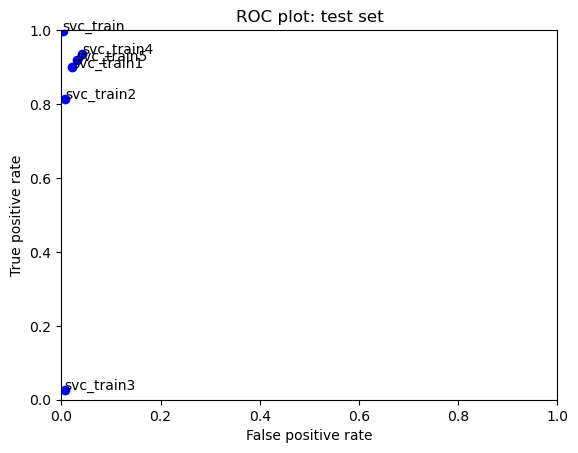

In [23]:
fits = [svc_performance_train, svc_performance_train1, svc_performance_train2, svc_performance_train3, svc_performance_train4, svc_performance_train5]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [25]:
prc_predictions = prc.predict(X_train)

### let's look at some false positives:

In [26]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(prc_predictions)):
    if (prc_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [27]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 1179, 'TN': 1307, 'FP': 1223, 'FN': 1291, 'Accuracy': 0.4972, 'Precision': 0.49084096586178183, 'Recall': 0.4773279352226721, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [28]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2047, 'TN': 2098, 'FP': 432, 'FN': 423, 'Accuracy': 0.829, 'Precision': 0.8257361839451391, 'Recall': 0.828744939271255, 'desc': 'svm_test'}


### MODEL: SVC

In [29]:
svc_performance_test = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test')
svc_performance_test.compute_measures()
print(svc_performance_test.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2193, 'TN': 2213, 'FP': 317, 'FN': 277, 'Accuracy': 0.8812, 'Precision': 0.8737051792828685, 'Recall': 0.8878542510121458, 'desc': 'svc_test'}


In [30]:
svc_performance_test1 = BinaryClassificationPerformance(svc1.predict(X_test), y_test, 'svc_test1')
svc_performance_test1.compute_measures()
print(svc_performance_test1.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 1911, 'TN': 2327, 'FP': 203, 'FN': 559, 'Accuracy': 0.8476, 'Precision': 0.9039735099337748, 'Recall': 0.7736842105263158, 'desc': 'svc_test1'}


In [31]:
svc_performance_test2 = BinaryClassificationPerformance(svc2.predict(X_test), y_test, 'svc_test2')
svc_performance_test2.compute_measures()
print(svc_performance_test2.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 1589, 'TN': 2438, 'FP': 92, 'FN': 881, 'Accuracy': 0.8054, 'Precision': 0.9452706722189174, 'Recall': 0.6433198380566801, 'desc': 'svc_test2'}


In [32]:
svc_performance_test3 = BinaryClassificationPerformance(svc3.predict(X_test), y_test, 'svc_test3')
svc_performance_test3.compute_measures()
print(svc_performance_test3.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 54, 'TN': 2517, 'FP': 13, 'FN': 2416, 'Accuracy': 0.5142, 'Precision': 0.8059701492537313, 'Recall': 0.02186234817813765, 'desc': 'svc_test3'}


In [33]:
svc_performance_test4 = BinaryClassificationPerformance(svc4.predict(X_test), y_test, 'svc_test4')
svc_performance_test4.compute_measures()
print(svc_performance_test4.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2096, 'TN': 2200, 'FP': 330, 'FN': 374, 'Accuracy': 0.8592, 'Precision': 0.8639736191261336, 'Recall': 0.848582995951417, 'desc': 'svc_test4'}


In [34]:
svc_performance_test5 = BinaryClassificationPerformance(svc5.predict(X_test), y_test, 'svc_test5')
svc_performance_test5.compute_measures()
print(svc_performance_test5.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2013, 'TN': 2268, 'FP': 262, 'FN': 457, 'Accuracy': 0.8562, 'Precision': 0.8848351648351649, 'Recall': 0.8149797570850202, 'desc': 'svc_test5'}


### MODEL: logistic regression

In [44]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2068, 'TN': 2092, 'FP': 438, 'FN': 402, 'Accuracy': 0.832, 'Precision': 0.825219473264166, 'Recall': 0.8372469635627531, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [45]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 1880, 'TN': 1859, 'FP': 671, 'FN': 590, 'Accuracy': 0.7478, 'Precision': 0.7369658957271659, 'Recall': 0.7611336032388664, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [46]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2027, 'TN': 2110, 'FP': 420, 'FN': 443, 'Accuracy': 0.8274, 'Precision': 0.8283612586841029, 'Recall': 0.8206477732793522, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [47]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2092, 'TN': 2083, 'FP': 447, 'FN': 378, 'Accuracy': 0.835, 'Precision': 0.8239464356045687, 'Recall': 0.8469635627530364, 'desc': 'rdg_test'}


In [48]:
rdg_p_test1 = BinaryClassificationPerformance(rdg_1.predict(X_test), y_test, 'rdg_test1')
rdg_p_test1.compute_measures()
print(rdg_p_test1.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2092, 'TN': 2083, 'FP': 447, 'FN': 378, 'Accuracy': 0.835, 'Precision': 0.8239464356045687, 'Recall': 0.8469635627530364, 'desc': 'rdg_test1'}


In [40]:
rdg_p_test2 = BinaryClassificationPerformance(rdg_2.predict(X_test), y_test, 'rdg_test2')
rdg_p_test2.compute_measures()
print(rdg_p_test2.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2093, 'TN': 2081, 'FP': 449, 'FN': 377, 'Accuracy': 0.8348, 'Precision': 0.8233674272226593, 'Recall': 0.8473684210526315, 'desc': 'rdg_test2'}


In [41]:
rdg_p_test3 = BinaryClassificationPerformance(rdg_3.predict(X_test), y_test, 'rdg_test3')
rdg_p_test3.compute_measures()
print(rdg_p_test3.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2093, 'TN': 2082, 'FP': 448, 'FN': 377, 'Accuracy': 0.835, 'Precision': 0.8236914600550964, 'Recall': 0.8473684210526315, 'desc': 'rdg_test3'}


In [42]:
rdg_p_test4 = BinaryClassificationPerformance(rdg_4.predict(X_test), y_test, 'rdg_test4')
rdg_p_test4.compute_measures()
print(rdg_p_test4.performance_measures)

NameError: name 'rdg_4' is not defined

In [43]:
rdg_p_test5 = BinaryClassificationPerformance(rdg_5.predict(X_test), y_test, 'rdg_test5')
rdg_p_test5.compute_measures()
print(rdg_p_test5.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2182, 'TN': 2192, 'FP': 338, 'FN': 288, 'Accuracy': 0.8748, 'Precision': 0.8658730158730159, 'Recall': 0.8834008097165992, 'desc': 'rdg_test5'}


### MODEL: Random Forest Classifier

In [49]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2470, 'Neg': 2530, 'TP': 2038, 'TN': 1022, 'FP': 1508, 'FN': 432, 'Accuracy': 0.612, 'Precision': 0.5747320924985899, 'Recall': 0.8251012145748988, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

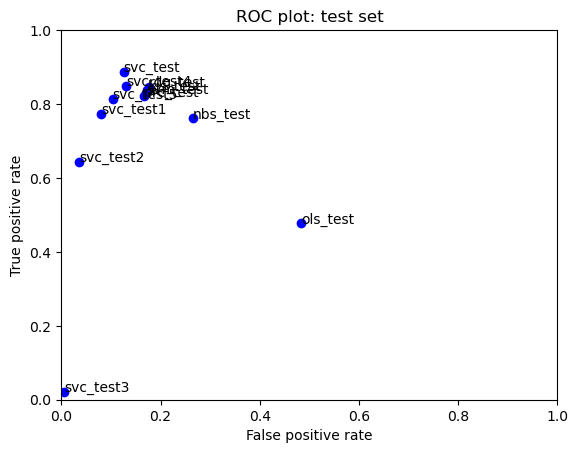

In [50]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, rdg_performance_test, prc_performance_test, svc_performance_test, svc_performance_test1, svc_performance_test2, svc_performance_test3, svc_performance_test4, svc_performance_test5]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [51]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=88, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
Shape of HashingVectorizer X:
(25000, 33554432)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9
5          89           5
6         112           9


---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [65]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svc.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.50152


In [67]:
raw_data.head(25)

,id,sentiment,review,word_count,punc_count
0,5814_8,1,With all this stuff going down at the moment w...,433,20
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",158,16
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,378,20
3,3630_4,0,It must be assumed that those who praised this...,379,8
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,367,9
5,8196_8,1,I dont know why people think this is such a ba...,89,5
6,7166_2,0,"This movie could have been very good, but come...",112,9
7,10633_1,0,I watched this video at a friend's house. I'm ...,132,9
8,319_1,0,"A friend of mine bought this film for £1, and ...",163,7
9,8713_10,1,<br /><br />This movie is full of references. ...,43,5


In [66]:
my_submission.head(25)

,id,prediction
0,5814_8,1
1,2381_9,1
2,7759_3,0
3,3630_4,0
4,9495_8,0
5,8196_8,1
6,7166_2,0
7,10633_1,0
8,319_1,0
9,8713_10,1


In [62]:
my_submission.shape

(25000, 2)

In [63]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission4.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation